# **Biblioteca**

In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 11.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import joblib
import emoji
import statsmodels.api as sm
import seaborn as sns
import matplotlib.image as mpimg
import itertools
import re
import pickle

In [ ]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
texto = pd.read_csv('toxic_language_train.csv')

# **Visualização**

In [ ]:
print('Quantidade de campos(colunas): ', texto.shape[1])
print('Total de registros:', texto.shape[0])

Quantidade de campos(colunas):  2
Total de registros: 16800


In [ ]:
texto.head(5)

,text,label
0,"rt @user olha quem chegouuuuu, nossos queridin...",0
1,veio umas teorias muito loucas na minha cabeça...,1
2,@user @user 😂😂😂😂mais nao tinha falado ontem qu...,0
3,rt @user quer ser filha da puta logo comigo qu...,1
4,vai besta 😂😂😂😂 casquei com a ultima foto,1


In [ ]:
texto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16800 non-null  object
 1   label   16800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 262.6+ KB


In [ ]:
print('quantidade de palavras tóxicas:', texto[texto['label'] == 1]['text'].count())
print('quantidade de plavras não tóxicas:', texto[texto['label'] == 0]['text'].count())


quantidade de palavras tóxicas: 7375
quantidade de plavras não tóxicas: 9425


# **Pré-Processamento**

In [ ]:
def pre_filtro(texto):

  #remove emojis
  texto = emoji.replace_emoji(texto, replace='')

  texto = re.sub(r'@\w+', '', texto)

  texto = re.sub(r'http\S+', '', texto)

  texto = re.sub(r'\b(rt|user|https|!)\b', '', texto, flags=re.IGNORECASE)

  return texto.strip()

texto['text'] = texto['text'].apply(pre_filtro)

print(texto[['text']].head)

<bound method NDFrame.head of                                                     text
0      olha quem chegouuuuu, nossos queridinhos!!! ve...
1      veio umas teorias muito loucas na minha cabeça...
2      mais nao tinha falado ontem que não ia ser pat...
3      quer ser filha da puta logo comigo que sou 50x...
4                   vai besta  casquei com a ultima foto
...                                                  ...
16795                         performer da nação caralho
16796       vôlei feminino é foda né, pqp, só vem tóquio
16797  cara de pau, quem desrespeita a constituição f...
16798  duas das grandes atletas do frescobol mundial....
16799      fui comprar um, sair com 7 brincos kkkkkk pqp

[16800 rows x 1 columns]>


In [ ]:
#separando de tóxico para não tóxico

lista_toxica = set(''.join(texto[texto['label'] == 1]['text']).split())
lista_n_toxica = set(''.join(texto[texto['label'] == 0]['text']).split())
lista_neutro = set.intersection(lista_toxica, lista_n_toxica)


In [ ]:
stopwords = set(stopwords.words('portuguese'))
lemmatizer = WordNetLemmatizer()

In [ ]:
#verificar se é tóxico

def e_toxico(text):
  for i in text.split():
    if i in lista_toxica:
      return 1
  return 0

#vereficar se n é tóxico

def n_e_toxico(text):
  for i in text.split():
    if i in lista_n_toxica:
      return 1
  return 0

#palavra neutra

def neutro_texto(text):
   palavra = text.split()
   for i in palavra:
      if i in lista_neutro:
        return 1
   return 0

#quantidade de palavras tóxicas

def count_toxic(text):
  count = 0
  for i in text.split():
    if i in lista_toxica:
      count += 1
  return count

#quantidade de palavras não tóxicas

def count_n_toxic(text):
  count = 0
  for i in text.split():
    if i in lista_n_toxica:
      count += 1
  return count


#contagem palavras neutras

def count_neutro(text):
  count = 0
  for i in text.split():
    if i in lista_neutro:
      count += 1
  return count

#removendo storpwords

def remove_stopwords(text):
  tokens = text.split()
  filtered_tokens = [word for word in tokens if word.lower() not in stopwords]
  return ' '.join(filtered_tokens)

#lematizando o texto

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)


In [ ]:
# Aplicar a função de remoção de stopwords aos dados
# Aplicar a função de lematização aos dados

texto['text'] = texto['text'].apply(remove_stopwords)
texto['text'] = texto['text'].apply(lemmatize_text)

In [ ]:
#Criação de Features

texto['palavras tóxicas'] = texto['text'].apply(e_toxico)

texto['palavras não tóxicas'] = texto['text'].apply(n_e_toxico)

texto['palavras neutras'] = texto['text'].apply(neutro_texto)

texto['contagem tóxica'] = texto['text'].apply(count_toxic)

texto['contagem não tóxica'] = texto['text'].apply(count_n_toxic)

texto['contagem neutras'] = texto['text'].apply(count_neutro)

texto['contagem de palavras'] = texto['text'].apply(lambda x: len(x.split()))

texto['contagem de letras'] = texto['text'].apply(lambda x: len(x))



In [ ]:
#Aplicando TF-IDF

X_text = texto['text']
X_outher_features = texto[['palavras tóxicas', 'palavras não tóxicas', 'palavras neutras', 'contagem tóxica', 'contagem não tóxica', 'contagem neutras', 'contagem de palavras', 'contagem de letras']]

tf_idf_vectorizer = TfidfVectorizer()
X_text = tf_idf_vectorizer.fit_transform(X_text)


In [ ]:
X = hstack([X_text, X_outher_features])
y = texto['label']

In [ ]:
joblib.dump(tf_idf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
#Salvando novo dataset

texto.to_csv('toxic_language_train_features.csv', index=False)

In [ ]:
#Transformação de dados
'''
Stopwords: palavras comuns, conjuções, preporsições:
e, ou, um, a
Removendo stop words podemos encontrar as palavras chaves


Stematização: serve para reduzir o vocabulario para reduizir o processamento de dados
corrida vira corr-
removre sufixos e prefixos

Lematização: reduz a palavra a sua forma base, preservando seu significado
corri vira correr
'''


'\nStopwords: palavras comuns, conjuções, preporsições:\ne, ou, um, a\nRemovendo stop words podemos encontrar as palavras chaves\n\n\nStematização: serve para reduzir o vocabulario para reduizir o processamento de dados\ncorrida vira corr-\nremovre sufixos e prefixos\n\nLematização: reduz a palavra a sua forma base, preservando seu significado\ncorri vira correr\n'

# **Qual modelo usar?**

---
# **Bibliotecas**


In [ ]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# **Árvore de Decisão**

In [ ]:
import itertools
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# CRIAR UM ALGORTIMO QUE SERÁ DO TIPO DE ÁRVORE DE DECISÃO
algortimo_arvore = DecisionTreeClassifier(criterion='entropy', max_depth=8)

#AGORA PRECISAMOS TREINÁ-LA
modelo = algortimo_arvore.fit(X_train, y_train)

[0.         0.         0.         ... 0.         0.00886714 0.        ]


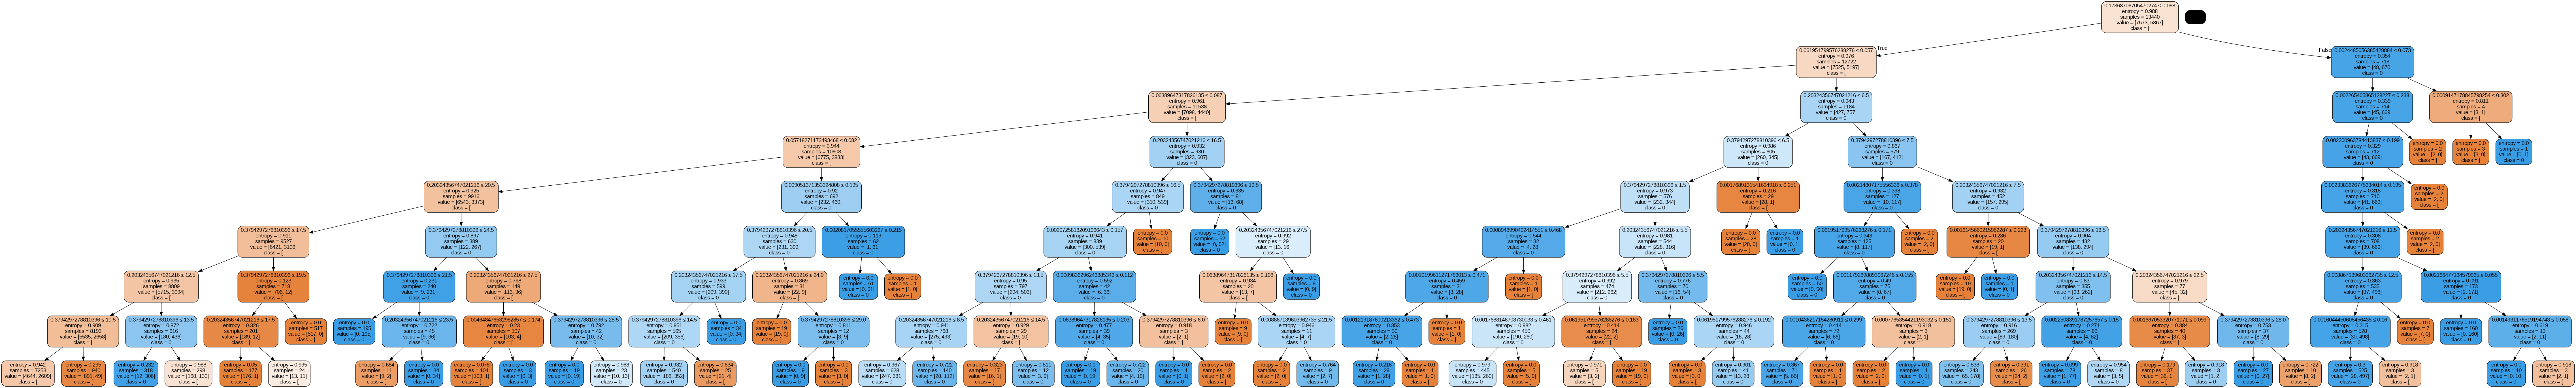

In [ ]:
#PODEMOS MOSTRAR A FEATURE MAIS IMPORTANTE (WHITE BOX?)
print (modelo.feature_importances_)


nome_features = modelo.feature_importances_
nome_classes = str(modelo.classes_)


# MONTAR A IMAGEM DA ÁRVORE
dot_data = StringIO()
export_graphviz(modelo, out_file = dot_data, filled=True, feature_names = nome_features, class_names = nome_classes, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png("arvore.png")
Image('arvore.png')


# **Métricas de Avaliação**

In [ ]:
def ver_diff(x,y):
  p_d = (x-y) * 100
  if p_d < 5:
    print('O modelo está sem overfitting!')
  elif 5 <= p_d <= 8:
    print('O modelo está com overfitting moderado!!')
  else:
    print('O modelo está com overfitting extremo!!!')



In [ ]:
pred_train = modelo.predict(X_train)
pred_test = modelo.predict(X_test)

In [ ]:
# Calcular a acurácia das previsões no conjunto de treinamento
accuracy_train_ad = accuracy_score(y_train, pred_train)
print(f"Acurácia (Treinamento) com as previsões já realizadas: {accuracy_train_ad * 100:.2f}%")

# Calcular a acurácia das previsões no conjunto de teste
accuracy_test_ad = accuracy_score(y_test, pred_test)
print(f"Acurácia (Teste) com as previsões já realizadas {accuracy_test_ad * 100:.2f}%")

# Calcular a diferença percentual entre as acurácias de treinamento e teste
percentage_difference_ad = (accuracy_train_ad - accuracy_test_ad) * 100
print(f"Diferença Percentual:{percentage_difference_ad:.2f} %")

print()

ver_diff(accuracy_train_ad, accuracy_test_ad)

Acurácia (Treinamento) com as previsões já realizadas: 73.12%
Acurácia (Teste) com as previsões já realizadas 71.76%
Diferença Percentual:1.36 %

O modelo está sem overfitting!


# **Regressão Logística**

In [ ]:
# Instancia e treina o modelo
lg = LogisticRegression()
lg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred_train = lg.predict(X_train)
y_pred_test = lg.predict(X_test)

In [ ]:
# Calcular a acurácia das previsões no conjunto de treinamento
accuracy_train_lg= accuracy_score(y_train, y_pred_train)
print(f"Acurácia (Treinamento) com as previsões já realizadas: {accuracy_train_lg * 100:.2f}%")

# Calcular a acurácia das previsões no conjunto de teste
accuracy_test_lg = accuracy_score(y_test, y_pred_test)
print(f"Acurácia (Teste) com as previsões já realizadas {accuracy_test_lg * 100:.2f}%")

# Calcular a diferença percentual entre as acurácias de treinamento e teste
percentage_difference_lg = (accuracy_train_lg - accuracy_test_lg) * 100
print(f"Diferença Percentual:{percentage_difference_lg:.2f} %")

print()

ver_diff(accuracy_train_lg, accuracy_test_lg)

Acurácia (Treinamento) com as previsões já realizadas: 90.07%
Acurácia (Teste) com as previsões já realizadas 86.64%
Diferença Percentual:3.43 %

O modelo está sem overfitting!


# **SVM**

In [ ]:
svm_model= SVC(kernel='linear', C=0.25)
svm_model.fit(X_train, y_train)

SVC(C=0.25, kernel='linear')

In [ ]:
print("ClassificationReport (Training Set):\n", classification_report(y_train, y_pred_train))

ClassificationReport (Training Set):
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      7573
           1       0.90      0.87      0.88      5867

    accuracy                           0.90     13440
   macro avg       0.90      0.90      0.90     13440
weighted avg       0.90      0.90      0.90     13440



In [ ]:
accuracy_train_SVM = accuracy_score(y_train, y_pred_train)
accuracy_test_SVM = accuracy_score(y_test, y_pred_test)
percentage_difference_SVM = (accuracy_train_SVM -accuracy_test_SVM) * 100

print(f"Acurácia (Treinamento) com as previsões já realizadas: {accuracy_train_SVM * 100:.2f}%")
print(f"Acurácia (Teste) com as previsões já realizadas: {accuracy_test_SVM * 100:.2f}%")
print(f"Diferença Percentual: {percentage_difference_SVM:.2f}%")

print()
ver_diff(accuracy_train_SVM, accuracy_test_SVM)

Acurácia (Treinamento) com as previsões já realizadas: 90.07%
Acurácia (Teste) com as previsões já realizadas: 86.64%
Diferença Percentual: 3.43%

O modelo está sem overfitting!


# **Comparação**

In [ ]:
def comparacao(**model_accuracies):
    if not model_accuracies:
        print("Nenhum modelo fornecido para comparação.")
        return

    # Converte as acurácias para porcentagem e formata
    accuracies_percent = {name: acc * 100 for name, acc in model_accuracies.items()}

    # Encontra o modelo com a melhor acurácia
    best_model = max(accuracies_percent, key=accuracies_percent.get)
    best_accuracy = accuracies_percent[best_model]

    print(f'O modelo com o melhor resultado é {best_model} com: {best_accuracy:.2f}%!')


In [ ]:
comparacao(
    Arvore_de_Decisao = accuracy_test_ad,
    Regressao_Logistica = accuracy_test_lg,
    SVM = accuracy_test_SVM
)

O modelo com o melhor resultado é Regressao_Logistica com: 86.64%!


# **Download modelos**

In [ ]:
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(lg, 'lg_model.pkl')
joblib.dump(modelo, 'arvore_model.pkl')

with open("palavras tóxicas.pkl", "wb") as file:
    pickle.dump('palavras tóxicas.pkl', file)

with open("palavras não tóxicas.pkl", "wb") as file:
    pickle.dump('palavras não tóxicas.pkl', file)

with open("palavras neutras.pkl", "wb") as file:
    pickle.dump('palavras neutras.pkl', file)

print('Os modelos foram baixados!')

Os modelos foram baixados!
